# DCGAN - Multi-class Classification (Type 0-4) - Diabetic Retinopathy

In [1]:
import os
import random
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.models import load_model
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import SGD,RMSprop,adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Data Loader

In [ ]:
listing = os.listdir("dataset/train_data/train/")
np.size(listing)

In [6]:
img_rows, img_cols = 200, 200

In [ ]:
immatrix = []
imlabel = []

with tqdm(listing) as pbar:
    for file in listing:
        base = os.path.basename("dataset/train_data/train/" + file)
        fileName = os.path.splitext(base)[0]
        imlabel.append(trainLabels.loc[trainLabels.image==fileName, 'level'].values[0])
        im = Image.open("dataset/train_data/train/" + file)   
        img = im.resize((img_rows,img_cols))
        gray = img.convert('L')
        immatrix.append(np.array(gray).flatten())
        pbar.update(1)

immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)

In [ ]:
np.save('immatrix_1', immatrix)
np.save('imlabel_1', imlabel)

In [7]:
immatrix = np.load('immatrix_1.npy')
imlabel = np.load('imlabel_1.npy')

## Data Preprocessing

In [8]:
data,Label = shuffle(immatrix,imlabel, random_state=2)
train_data = [data,Label]

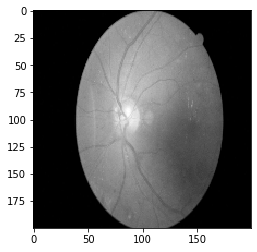

In [9]:
img=immatrix[200].reshape(img_rows,img_cols)
plt.imshow(img)
plt.imshow(img,cmap='gray')

In [10]:
batch_size = 48
nb_classes = 5
nb_epoch = 150
nb_filters = 32
nb_pool = 2
nb_conv = 3

(X, y) = (train_data[0],train_data[1])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print(X_train.shape)
print(X_test.shape)

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

(2800, 40000)
(700, 40000)
X_train shape: (2800, 200, 200, 1)
2800 train samples
700 test samples


In [12]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## CNN Model Distribution

In [13]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_cols, img_rows, 1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(200, 200,..., padding="valid")`
  """
/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  


In [14]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 196, 196, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 307328)           

### Data Augmentation

In [15]:
validationdatagenerator = ImageDataGenerator()
traindatagenerator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

train_generator=traindatagenerator.flow(X_train, Y_train, batch_size=batch_size) 
validation_generator=validationdatagenerator.flow(X_test, Y_test,batch_size=batch_size)

## Training

In [16]:
history_1 = model.fit_generator(train_generator, verbose=1, steps_per_epoch=int(len(X_train)/batch_size), epochs=nb_epoch, validation_data=validation_generator, validation_steps=int(len(X_test)/batch_size))

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
58/58 [==============================] - 17s 300ms/step - loss: 1.6919 - accuracy: 0.2384 - val_loss: 1.6305 - val_accuracy: 0.3095
Epoch 2/150
58/58 [==============================] - 15s 263ms/step - loss: 1.5875 - accuracy: 0.2609 - val_loss: 1.5759 - val_accuracy: 0.3221
Epoch 3/150
58/58 [==============================] - 16s 273ms/step - loss: 1.5767 - accuracy: 0.2823 - val_loss: 1.5639 - val_accuracy: 0.3221
Epoch 4/150
58/58 [==============================] - 17s 286ms/step - loss: 1.5444 - accuracy: 0.2976 - val_loss: 1.6681 - val_accuracy: 0.2607
Epoch 5/150
58/58 [==============================] - 19s 328ms/step - loss: 1.5367 - accuracy: 0.3114 - val_loss: 1.5424 - val_accuracy: 0.3620
Epoch 6/150
58/58 [==============================] - 20s 344ms/step - loss: 1.5111 - accuracy: 0.3147 - val_loss: 1.4843 - val_accuracy: 0.3635
Epoch 7/150
58/58 [==============================] - 22s 385ms/step - loss: 1.5187 - acc

Epoch 56/150
58/58 [==============================] - 29s 499ms/step - loss: 1.4420 - accuracy: 0.3876 - val_loss: 1.4118 - val_accuracy: 0.3911
Epoch 57/150
58/58 [==============================] - 29s 503ms/step - loss: 1.4230 - accuracy: 0.3844 - val_loss: 1.3895 - val_accuracy: 0.4632
Epoch 58/150
58/58 [==============================] - 29s 506ms/step - loss: 1.4244 - accuracy: 0.3823 - val_loss: 1.2270 - val_accuracy: 0.4248
Epoch 59/150
58/58 [==============================] - 31s 539ms/step - loss: 1.4144 - accuracy: 0.3852 - val_loss: 1.3692 - val_accuracy: 0.4294
Epoch 60/150
58/58 [==============================] - 34s 586ms/step - loss: 1.4116 - accuracy: 0.3797 - val_loss: 1.1901 - val_accuracy: 0.4479
Epoch 61/150
58/58 [==============================] - 38s 653ms/step - loss: 1.4239 - accuracy: 0.4008 - val_loss: 1.4093 - val_accuracy: 0.4375
Epoch 62/150
58/58 [==============================] - 40s 689ms/step - loss: 1.4360 - accuracy: 0.3765 - val_loss: 1.4511 - val_ac

In [17]:
model.save("model_48_150.h5")
print("Saved model to disk")

Saved model to disk


### Training Loss Plot

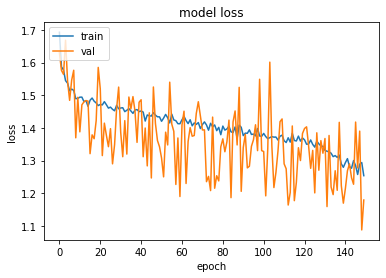

In [18]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Training Accuracy Plot

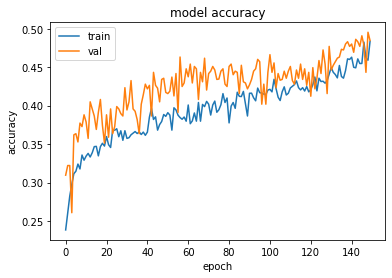

In [19]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evalutation - Model Loss & Accuracy

In [20]:
scores = model.evaluate(X_test, Y_test)
print(scores)

700/700 [==============================] - 1s 2ms/step
[1.2610167183194843, 0.49000000953674316]


### Confusion Matrix

In [21]:
y_pred = model.predict(X_test, verbose=1)

700/700 [==============================] - 1s 2ms/step


In [22]:
metrics.confusion_matrix(Y_test.argmax(axis=-1), y_pred.argmax(axis=-1))

array([[115,   5,  12,   5,   3],
       [ 21,  73,  37,   9,   6],
       [ 35,  39,  46,   8,   5],
       [ 10,  33,  24,  52,  18],
       [ 11,  21,  23,  32,  57]], dtype=int64)

### Accuracy

In [23]:
print("Accuracy: ", np.mean(Y_test.argmax(axis=-1) == y_pred.argmax(axis=-1)) * 100)

Accuracy:  49.0


### Precision, Recall & F1 Score - Classification Report

In [24]:
print(metrics.classification_report(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69       192
           1       0.50      0.43      0.46       171
           2       0.35      0.32      0.33       142
           3       0.38      0.49      0.43       106
           4       0.40      0.64      0.49        89

    accuracy                           0.49       700
   macro avg       0.49      0.50      0.48       700
weighted avg       0.53      0.49      0.50       700



## Training

In [25]:
history_2 = model.fit_generator(train_generator, verbose=1, steps_per_epoch=int(len(X_train)/batch_size), epochs=50, validation_data=validation_generator, validation_steps=int(len(X_test)/batch_size))

Epoch 1/50
58/58 [==============================] - 19s 319ms/step - loss: 1.2811 - accuracy: 0.4473 - val_loss: 1.2427 - val_accuracy: 0.4479
Epoch 2/50
58/58 [==============================] - 19s 321ms/step - loss: 1.2570 - accuracy: 0.4738 - val_loss: 1.1426 - val_accuracy: 0.4509
Epoch 3/50
58/58 [==============================] - 18s 314ms/step - loss: 1.2756 - accuracy: 0.4695 - val_loss: 1.2787 - val_accuracy: 0.4755
Epoch 4/50
58/58 [==============================] - 18s 318ms/step - loss: 1.2699 - accuracy: 0.4742 - val_loss: 1.1072 - val_accuracy: 0.4509
Epoch 5/50
58/58 [==============================] - 18s 314ms/step - loss: 1.2655 - accuracy: 0.4651 - val_loss: 1.3324 - val_accuracy: 0.4893
Epoch 6/50
58/58 [==============================] - 18s 313ms/step - loss: 1.2597 - accuracy: 0.4818 - val_loss: 1.2295 - val_accuracy: 0.4908
Epoch 7/50
58/58 [==============================] - 18s 314ms/step - loss: 1.2565 - accuracy: 0.4789 - val_loss: 1.3872 - val_accuracy: 0.4755

### Training Loss Plot

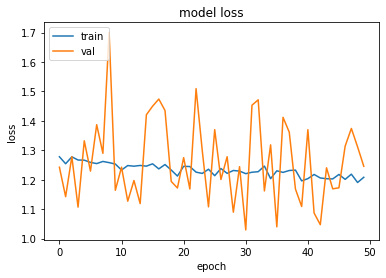

In [26]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Training Accuracy Plot

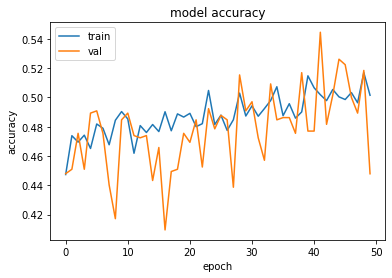

In [27]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
model.save("model_48_200.h5")
print("Saved model to disk")

Saved model to disk


## Evalutation - Model Loss & Accuracy

In [29]:
scores = model.evaluate(X_test, Y_test)
print(scores)

700/700 [==============================] - 1s 1ms/step
[1.2803135565349033, 0.44857141375541687]


### Confusion Matrix

In [30]:
y_pred = model.predict(X_test, verbose=1)
metrics.confusion_matrix(Y_test.argmax(axis=-1), y_pred.argmax(axis=-1))

700/700 [==============================] - 1s 1ms/step


array([[65,  4, 64,  4,  3],
       [ 6, 47, 51, 34,  8],
       [15, 30, 69, 12,  7],
       [ 1, 20, 27, 67, 22],
       [ 3,  9, 28, 38, 66]], dtype=int64)

### Accuracy

In [31]:
print("Accuracy: ", np.mean(Y_test.argmax(axis=-1) == y_pred.argmax(axis=-1)) * 100)

Accuracy:  44.857142857142854


### Precision, Recall & F1 Score - Classification Report

In [32]:
print(metrics.classification_report(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.46      0.72      0.57        90
           1       0.32      0.43      0.37       110
           2       0.52      0.29      0.37       239
           3       0.49      0.43      0.46       155
           4       0.46      0.62      0.53       106

    accuracy                           0.45       700
   macro avg       0.45      0.50      0.46       700
weighted avg       0.47      0.45      0.44       700



## Training

In [33]:
history_3 = model.fit_generator(train_generator, verbose=1, steps_per_epoch=int(len(X_train)/batch_size), epochs=100, validation_data=validation_generator, validation_steps=int(len(X_test)/batch_size))

Epoch 1/100
58/58 [==============================] - 19s 319ms/step - loss: 1.2123 - accuracy: 0.5025 - val_loss: 1.0845 - val_accuracy: 0.4866
Epoch 2/100
58/58 [==============================] - 19s 323ms/step - loss: 1.2071 - accuracy: 0.5142 - val_loss: 1.1245 - val_accuracy: 0.5061
Epoch 3/100
58/58 [==============================] - 19s 323ms/step - loss: 1.2039 - accuracy: 0.4953 - val_loss: 1.1593 - val_accuracy: 0.5061
Epoch 4/100
58/58 [==============================] - 19s 319ms/step - loss: 1.2112 - accuracy: 0.5044 - val_loss: 1.3382 - val_accuracy: 0.5307
Epoch 5/100
58/58 [==============================] - 18s 318ms/step - loss: 1.1825 - accuracy: 0.5156 - val_loss: 1.2864 - val_accuracy: 0.5031
Epoch 6/100
58/58 [==============================] - 19s 319ms/step - loss: 1.2069 - accuracy: 0.4967 - val_loss: 1.0327 - val_accuracy: 0.5245
Epoch 7/100
58/58 [==============================] - 19s 325ms/step - loss: 1.1945 - accuracy: 0.5073 - val_loss: 1.3105 - val_accuracy:

### Training Loss Plot

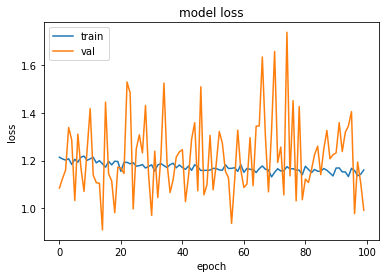

In [34]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Training Accuracy Plot

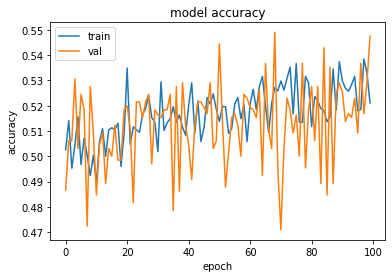

In [35]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
model.save("model_48_300.h5")
print("Saved model to disk")

Saved model to disk


## Evalutation - Model Loss & Accuracy

In [37]:
scores = model.evaluate(X_test, Y_test)
print(scores)

700/700 [==============================] - 1s 1ms/step
[1.1412777655465263, 0.5328571200370789]


### Confusion Matrix

In [38]:
y_pred = model.predict(X_test, verbose=1)
metrics.confusion_matrix(Y_test.argmax(axis=-1), y_pred.argmax(axis=-1))

700/700 [==============================] - 1s 1ms/step


array([[116,   6,  17,   1,   0],
       [ 16,  77,  41,  10,   2],
       [ 27,  45,  55,   4,   2],
       [  2,  32,  19,  57,  27],
       [  8,  16,  19,  33,  68]], dtype=int64)

### Accuracy

In [39]:
print("Accuracy: ", np.mean(Y_test.argmax(axis=-1) == y_pred.argmax(axis=-1)) * 100)

Accuracy:  53.28571428571428


### Precision, Recall & F1 Score - Classification Report

In [40]:
print(metrics.classification_report(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75       169
           1       0.53      0.44      0.48       176
           2       0.41      0.36      0.39       151
           3       0.42      0.54      0.47       105
           4       0.47      0.69      0.56        99

    accuracy                           0.53       700
   macro avg       0.53      0.54      0.53       700
weighted avg       0.55      0.53      0.53       700



# Adversarial Attacks

In [15]:
loaded_model = load_model('model_48_300.h5')
loaded_model.trainable=False

In [16]:
fmodel = foolbox.models.KerasModel(loaded_model, bounds=(0, 255))
print("Mean Accuracy for Predictions on Original Data: {0:.2f}%".format(np.mean(fmodel.forward(X_test).argmax(axis=1) == Y_test.argmax(axis=1)) * 100))

Mean Accuracy for Predictions on Original Data: 53.29%


## 1. FGSM Attack

In [17]:
# (a) attack 1

attack_2 = foolbox.attacks.FGSM(fmodel)
adversarials_2 = attack_2(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by FGSM Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_2).argmax(axis=-1) == y_test) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by FGSM Attack: 0.43%


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


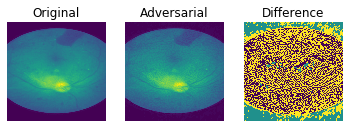

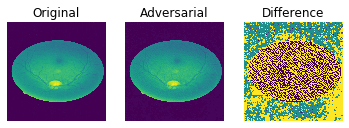

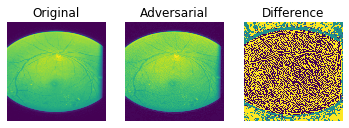

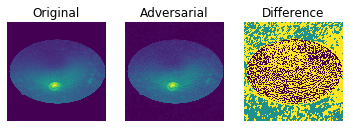

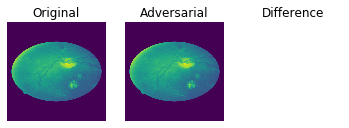

In [19]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_2[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 2. Spatial Attack

In [33]:
# (a) attack 2

attack_2 = foolbox.attacks.SpatialAttack(fmodel)
adversarials_2 = attack_2(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by Spatial Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_2).argmax(axis=-1) == Y_test.argmax(axis=-1)) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: SpatialAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by Spatial Attack: 5.57%


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


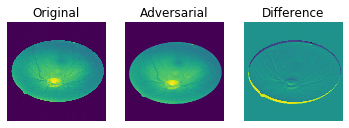

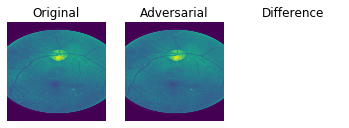

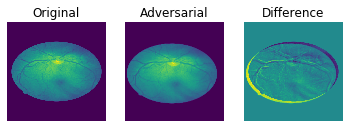

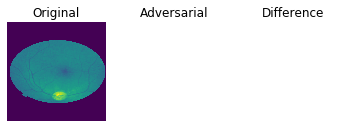

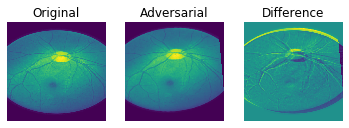

In [34]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_2[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 3. Deep Fool Attack

In [25]:
# (a) attack 3

attack_3 = foolbox.attacks.DeepFoolAttack(fmodel)
adversarials_3 = attack_3(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by Deep Fool Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_3).argmax(axis=-1) == y_test) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: DeepFoolAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by Deep Fool Attack: 2.29%


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


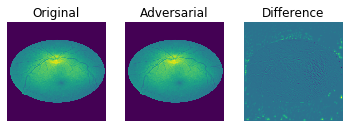

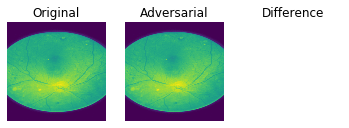

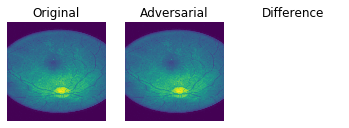

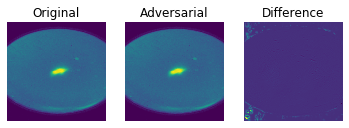

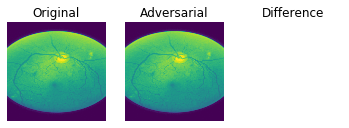

In [29]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_3[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 4. Inversion Attack

In [20]:
# (a) attack 4

attack_4 = foolbox.attacks.InversionAttack(fmodel)
adversarials_4 = attack_4(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by Inversion Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_4).argmax(axis=-1) == y_test) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: InversionAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by Inversion Attack: 9.71%


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


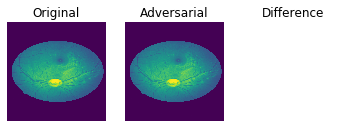

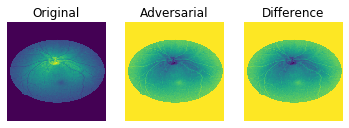

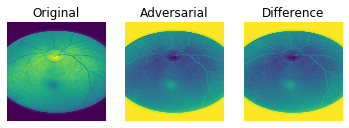

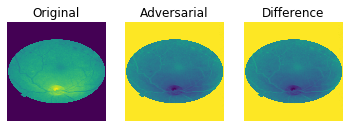

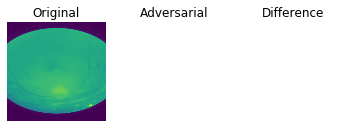

In [24]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_4[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 5. Gaussian Blur Attack

In [30]:
# (a) attack 5

attack_5 = foolbox.attacks.GaussianBlurAttack(fmodel)
adversarials_5 = attack_5(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by Gaussian Blur Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_5).argmax(axis=-1) == y_test) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: GaussianBlurAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by Gaussian Blur Attack: 6.00%


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


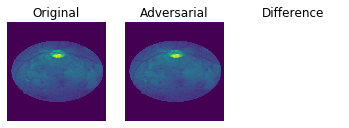

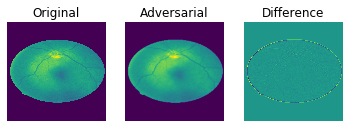

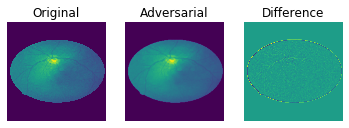

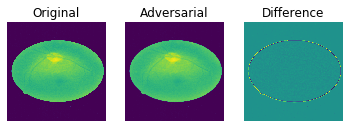

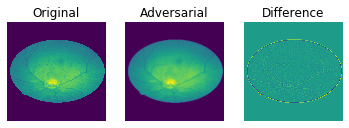

In [32]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_5[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()